In [2]:
!pip install ortools #the installation line below works in colab, change if it doesn't work for your environment
from ortools.sat.python import cp_model

################################################################################
################    READ BOARD    ##############################################
def ReadBoard(text):
  target = "/content/drive/My Drive/CS 404/HW2/" + text #again change the address
  file = open(target, 'r')

  lines = file.readlines()

  Board = []
  print("\n\ncurrent board is:", text, "\nPlease see the Documentation for better visualising\n")
  for r in range(len(lines)):
    row = lines[r].strip()
    print(row)
    Board.append(row.split(" "))

  return Board
################################################################################
################    Solution Printer    ########################################
class PrintSolutions(cp_model.CpSolverSolutionCallback): 
# this is mostly taken from OR-tools documentation with slight modifications
  def __init__(self, variables, limit):
    cp_model.CpSolverSolutionCallback.__init__(self)
    self.__variables = variables
    self.__solution_count = 0
    self.__solution_limit = limit
    self.solution_list = []

  def on_solution_callback(self):
    self.__solution_count += 1
    self.solution_list.append([self.Value(v) for v in self.__variables])
    if self.__solution_count >= self.__solution_limit:
      print('\n\nStopped search after %i solutions' % self.__solution_limit)
      self.StopSearch()
################################################################################
################    Read Variables    ##########################################
def ReadVariables(model,Board,game_board,all_variables,row_variable_indices,column_variable_indices):
  rows = len(Board)
  cols = len(Board[0])

  # This loop reads the Board and changes 0's to CSP variables, strips the first
  # row and column which were for the required number of filled squares
  for i in range(1,rows):
    for j in range(1,cols):
      if Board[i][j] == '0': #variables are 0's, they will be assigned between 0 and 1
        game_board[(i,j)] = model.NewIntVar(0,1,'var(%d,%d)' % (i,j))

      else: #anything else in the actual board (not in the 1st column or row) is not variable (8 and 9's)
        game_board[(i,j)] = int(Board[i][j])


  for i in range(1,rows): 
    row_variable_indices[i] = []
    for j in range(1,cols):
      if game_board[(i,j)] == -1: #this detects Variables, CSP Variables (IntVar) were giving true for any
      #IntVar == int, so I decided to use -1 to detect variables as there will be no -1 in Board guaranteed
        row_variable_indices[i].append(j)
        all_variables.append(game_board[(i,j)]) # while iterating over the list, Extracting all variables too

  for j in range(1,cols):
    column_variable_indices[j] = []
    for i in range(1,rows):
      if game_board[(i,j)] == -1:
        column_variable_indices[j].append(i)
################################################################################
################    Add Constraints    #########################################
def AddConstraints(model,Board,game_board,row_variable_indices,column_variable_indices):
  # add constraint that addition of all variables in that row will be equal to
  # desired value given in the first column of board
  for row in row_variable_indices:
    if len(row_variable_indices[row]) != 0: #if that row has variables
      Required = int(Board[row][0]) #the required value of filled squares in that row
      model.Add(sum(game_board[(row,row_variable_indices[row][column])] for column in range(len(row_variable_indices[row]))) == Required)
      

  # do the same thing for columns
  for column in column_variable_indices:
    if len(column_variable_indices[column]) != 0:

      Required = int(Board[0][column])
      model.Add(sum(game_board[(column_variable_indices[column][row],column)] for row in range(len(column_variable_indices[column]))) == Required)
     

  #this will add constraint, that if a block is filled, its bottom and right should
  #be filled too, I am not checking left's because constraints will be assigned from
  #left to right and assigning something like a == a_left, where a_left were already
  #assigned to a (as it is its right) would be unnecessary
  for row in row_variable_indices:
    for column in row_variable_indices[row]:
      #if right is free block or variable, make current equal to right
      #again this finds variable by just Variable == 8, even Variables ar 0 initially
      #Since, IntVar == int returns True for all integers, so there is a second if
      if (column+1 <= max(column_variable_indices)) and (game_board[(row,column+1)] == 8):
        if (game_board[(row,column+1)] == -1): #if right is variable
          print("\n\na\n\n")
          model.Add(game_board[(row,column)] == game_board[(row,column+1)]).OnlyEnforceIf(game_board[(row,column+1)] == 0)
          
        else: #right is free block
          model.Add(game_board[(row,column)] == game_board[(row,column+2)])
         
      
      #same thing for below, but add only if below is 0
      #meaning if bottom is 0, top should also be 0; if bottom is 1 top can be any
      if (row+1 <= max(row_variable_indices)) and (game_board[(row+1,column)] == 8):
        a = model.NewBoolVar('a') 
        if (game_board[(row+1,column)] == -1): #if below is variable
          # depending on two value of BoolVar a (True and False) there are two cases
          model.Add(game_board[(row+1,column)] == 0).OnlyEnforceIf(a) # if a is set to True, the upper block will always be set to empty
          model.Add(game_board[(row,column)] == game_board[(row+1,column)]).OnlyEnforceIf(a) # so, upper block should be equal to bottom one

          model.Add(game_board[(row+1,column)] == 1).OnlyEnforceIf(a.Not()) # if a is set to False, bottom one will be filled so top can be anything

          
        else: #below is free block
          model.Add(game_board[(row+2,column)] == 0).OnlyEnforceIf(a)
          model.Add(game_board[(row,column)] == game_board[(row+2,column)]).OnlyEnforceIf(a)

          model.Add(game_board[(row+2,column)] == 1).OnlyEnforceIf(a.Not())
################################################################################
################    Main   #####################################################
def main():
  Board = ReadBoard("10x10.txt") #change the initial directory in the function before runing
  game_board = {}
  all_variables = []
  row_variable_indices = {}
  column_variable_indices = {}

  model = cp_model.CpModel()

  ReadVariables(model,Board,game_board,all_variables,row_variable_indices,column_variable_indices)
  AddConstraints(model,Board,game_board,row_variable_indices,column_variable_indices)

  solver = cp_model.CpSolver()
  solutions = PrintSolutions(all_variables, 1) #1 indicates, search will stop after finding 1 solution
  #but as there is at most 1 solution for puzzles used (Status "OPTIMAL" means all solutions found as far as I understood
  #it is "FEASIBLE" if limited ammount of solutions were found among more available), I originially did it for testings I used

  status = solver.SearchForAllSolutions(model, solutions)
  print("Status = %s\n" % solver.StatusName(status))

  for sol in solutions.solution_list: 
    print(sol)


main()

     |████████████████████████████████| 13.7MB 6.1MB/s 
     |████████████████████████████████| 1.0MB 34.2MB/s 
  Found existing installation: protobuf 3.12.4
    Uninstalling protobuf-3.12.4:
      Successfully uninstalled protobuf-3.12.4




current board is: 10x10.txt 
Please see the Documentation for better visualising

8 3 8 6 8 4 8 5 8 3 8 5 8 7 8 6 8 3 8 4
8 0 9 0 8 0 8 0 8 0 8 0 8 0 8 0 8 0 9 0
8 8 9 9 9 9 9 8 9 9 9 8 8 8 8 8 9 9 9 8
5 0 8 0 9 0 9 0 9 0 9 0 8 0 8 0 9 0 9 0
8 8 8 8 9 8 9 9 9 8 9 9 9 9 9 9 9 8 9 9
2 0 8 0 9 0 9 0 8 0 9 0 8 0 8 0 8 0 9 0
8 9 9 8 9 8 9 9 9 8 9 9 9 9 9 9 9 8 9 8
7 0 9 0 9 0 8 0 9 0 9 0 8 0 8 0 9 0 9 0
8 8 9 9 9 9 9 9 9 8 9 9 9 8 9 9 9 8 9 9
4 0 8 0 8 0 9 0 8 0 8 0 9 0 9 0 8 0 9 0
8 8 8 8 8 8 9 9 9 9 9 9 9 8 9 8 9 9 9 8
3 0 8 0 8 0 8 0 9 0 8 0 8 0 9 0 9 0 9 0
8 9 9 8 8 8 9 9 9 9 9 9 9 9 9 8 9 8 9 8
1 0 9 0 8 0 9 0 8 0 9 0 8 0 9 0 9 0 9 0
8 8 9 8 9 9 9 8 8 8 9 8 9 9 9 9 9 8 9 8
1 0 9 0 9 0 8 0 8 0 9 0 9 0 8 0 8 0 9 0
8 8 9 9 9 9 9 8 8 8 9 8 9 8 8 8 8 8 9 8
7 0 8 0 8 0 9 0 8 0 9 0 9 0 8 0 8 0 9 0
8 9 9 9 9 9 9 8 9 9 9 8 9 8 8 8 8 8 9 9
8 0 8 0 8 0 8 0 9 0 8 0 9 0 8 0 8 0 8 0


Stopped search after 1 solutions
Status = OPTIMAL

[0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1,

# sample

0, 0, 0, 0, 0, 1, 1, 1, 1, 0

0, 0, 0, 1, 1, 1, 1, 0, 0, 0

0, 0, 1, 1, 1, 1, 0, 0, 0, 0

0, 1, 1, 0, 1, 1, 0, 0, 0, 0

0, 0, 1, 0, 0, 0, 0, 1, 1, 1

0, 0, 0, 0, 0, 1, 1, 1, 1, 0

0, 1, 1, 0, 0, 1, 1, 0, 0, 0

1, 1, 0, 0, 0, 1, 0, 0, 0, 0

1, 1, 0, 0, 0, 1, 1, 1, 0, 1

1, 1, 1, 1, 0, 0, 0, 0, 1, 1

1, 1, 0, 0, 0, 0

0, 1, 1, 0, 0, 0

1, 1, 1, 1, 0, 0

0, 1, 1, 0, 0, 1

1, 0, 0, 0, 1, 1

1, 1, 0, 0, 0, 0

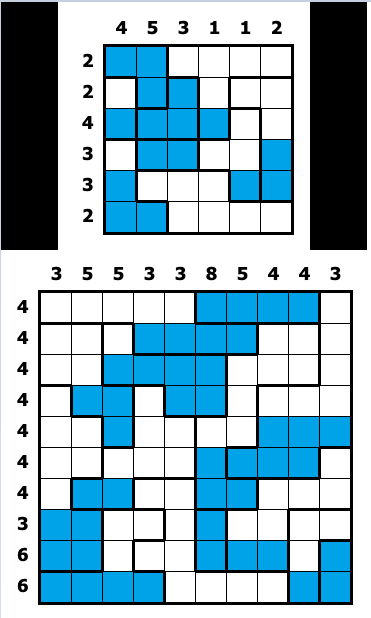